Muhammad Aizar Yazid / 1103223097

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [121]:
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
data = pd.read_csv(url)

print(data)

       Unnamed: 0  Clothing ID  Age  \
0               0          767   33   
1               1         1080   34   
2               2         1077   60   
3               3         1049   50   
4               4          847   47   
...           ...          ...  ...   
23481       23481         1104   34   
23482       23482          862   48   
23483       23483         1104   31   
23484       23484         1084   28   
23485       23485         1104   52   

                                                   Title  \
0                                                    NaN   
1                                                    NaN   
2                                Some major design flaws   
3                                       My favorite buy!   
4                                       Flattering shirt   
...                                                  ...   
23481                     Great dress for many occasions   
23482                         Wish it was made of c

In [122]:
# Handle missing values
data['Review Text'] = data['Review Text'].fillna('No Review')
data['Title'] = data['Title'].fillna('No Title')
data['Division Name'] = data['Division Name'].fillna(data['Division Name'].mode()[0])
data['Department Name'] = data['Department Name'].fillna(data['Department Name'].mode()[0])
data['Class Name'] = data['Class Name'].fillna(data['Class Name'].mode()[0])

# Preprocess Review Text (remove punctuation, lowercase, etc.)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['Review Text'] = data['Review Text'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Vectorize text data using TF-IDF and keep the result as a sparse matrix
vectorizer = TfidfVectorizer(max_features=5000)
X_text_sparse = vectorizer.fit_transform(data['Review Text'])

# Normalize numerical columns
scaler = StandardScaler()
X_num = scaler.fit_transform(data[['Age', 'Rating', 'Positive Feedback Count']])

# Encode categorical variables
label_encoder = LabelEncoder()
X_cat = data[['Division Name', 'Department Name', 'Class Name']].apply(label_encoder.fit_transform).to_numpy()

# Combine all features into one dataset
from scipy.sparse import hstack
X = hstack([X_text_sparse, X_num, X_cat])

# Target variable
y = data['Recommended IND']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)  # Convert sparse to dense for RNN
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Reshape data to fit RNN input shape (batch_size, sequence_length, input_dim)
X_train_rnn = X_train_tensor.unsqueeze(1)  # Add sequence length dimension (1 in our case)
X_test_rnn = X_test_tensor.unsqueeze(1)


RNN Model

In [124]:
# Define the RNN model class
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Use the output of the last time step
        out = self.fc(out)
        return out

In [129]:
# Initialize model, loss function, and optimizer
model = RNNModel(input_dim=X_train_rnn.shape[2], hidden_dim=128, output_dim=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, X_train, y_train, criterion, optimizer, epochs=30):
    train_loss = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return train_loss

train_loss = train_model(model, X_train_rnn, y_train_tensor, criterion, optimizer, epochs=30)

Epoch [2/30], Loss: 0.5787
Epoch [4/30], Loss: 0.5129
Epoch [6/30], Loss: 0.4744
Epoch [8/30], Loss: 0.4546
Epoch [10/30], Loss: 0.4447
Epoch [12/30], Loss: 0.4382
Epoch [14/30], Loss: 0.4311
Epoch [16/30], Loss: 0.4219
Epoch [18/30], Loss: 0.4103
Epoch [20/30], Loss: 0.3970
Epoch [22/30], Loss: 0.3833
Epoch [24/30], Loss: 0.3701
Epoch [26/30], Loss: 0.3582
Epoch [28/30], Loss: 0.3477
Epoch [30/30], Loss: 0.3382


In [130]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    auc = roc_auc_score(y_test, outputs[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, outputs[:, 1])

    return accuracy, precision, recall, f1, auc, fpr, tpr

accuracy, precision, recall, f1, auc, fpr, tpr = evaluate_model(model, X_test_rnn, y_test_tensor)


Accuracy: 0.8395
Precision: 0.8364
Recall: 0.9995
F1 Score: 0.9107
AUC: 0.9611


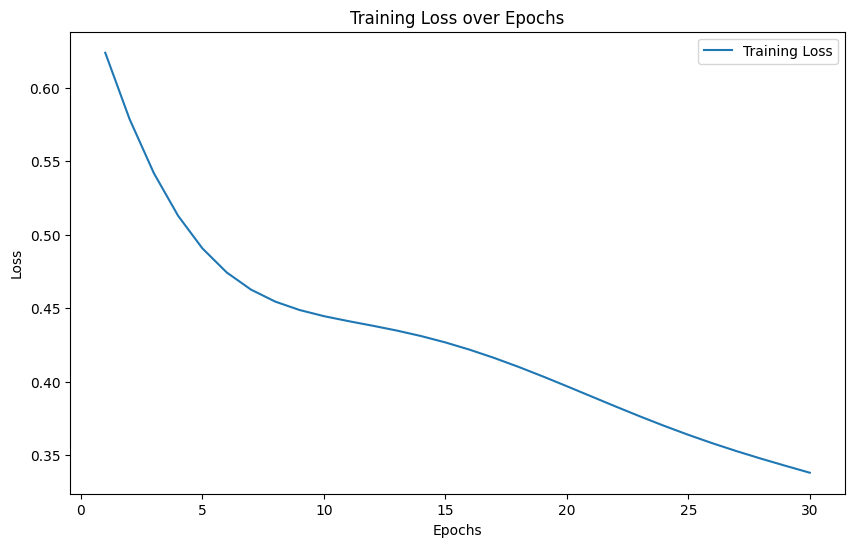

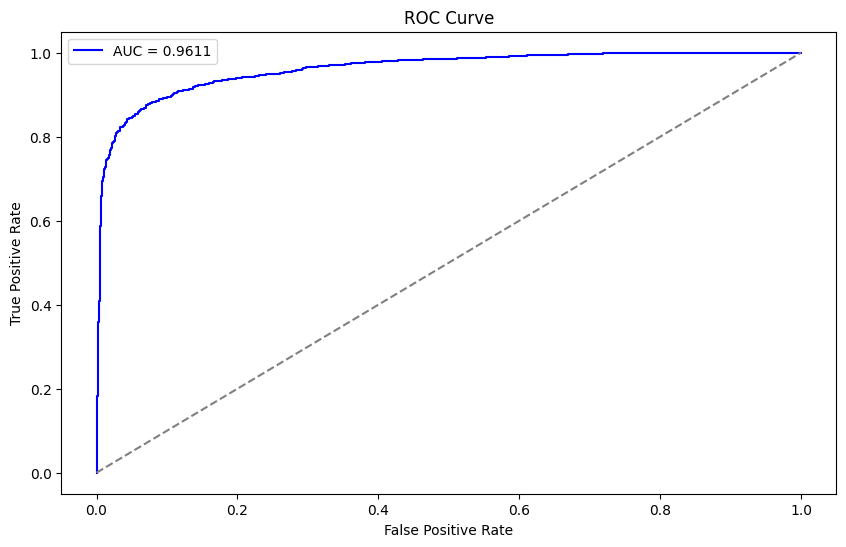

In [131]:
# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

LSTM Model

In [137]:
# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use the output of the last time step
        out = self.fc(out)
        return out

In [141]:
# Initialize model, loss function, and optimizer
model_lstm = LSTMModel(input_dim=X_train_rnn.shape[2], hidden_dim=128, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the LSTM model
train_loss_lstm = train_model(model_lstm, X_train_rnn, y_train_tensor, criterion, optimizer, epochs=50)

# Evaluate the model on the test set
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm, auc_lstm, fpr_lstm, tpr_lstm = evaluate_model(model_lstm, X_test_rnn, y_test_tensor)

Epoch [2/50], Loss: 0.7015
Epoch [4/50], Loss: 0.6685
Epoch [6/50], Loss: 0.6381
Epoch [8/50], Loss: 0.6101
Epoch [10/50], Loss: 0.5841
Epoch [12/50], Loss: 0.5601
Epoch [14/50], Loss: 0.5380
Epoch [16/50], Loss: 0.5178
Epoch [18/50], Loss: 0.4998
Epoch [20/50], Loss: 0.4840
Epoch [22/50], Loss: 0.4704
Epoch [24/50], Loss: 0.4591
Epoch [26/50], Loss: 0.4500
Epoch [28/50], Loss: 0.4426
Epoch [30/50], Loss: 0.4366
Epoch [32/50], Loss: 0.4314
Epoch [34/50], Loss: 0.4266
Epoch [36/50], Loss: 0.4217
Epoch [38/50], Loss: 0.4164
Epoch [40/50], Loss: 0.4106
Epoch [42/50], Loss: 0.4042
Epoch [44/50], Loss: 0.3974
Epoch [46/50], Loss: 0.3902
Epoch [48/50], Loss: 0.3826
Epoch [50/50], Loss: 0.3749


Accuracy: 0.8206
Precision: 0.8203
Recall: 1.0000
F1 Score: 0.9013
AUC: 0.8646


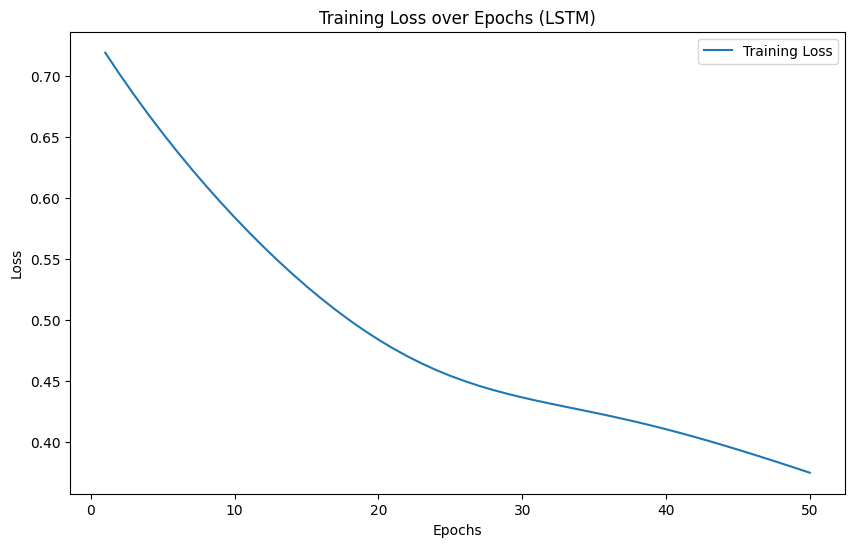

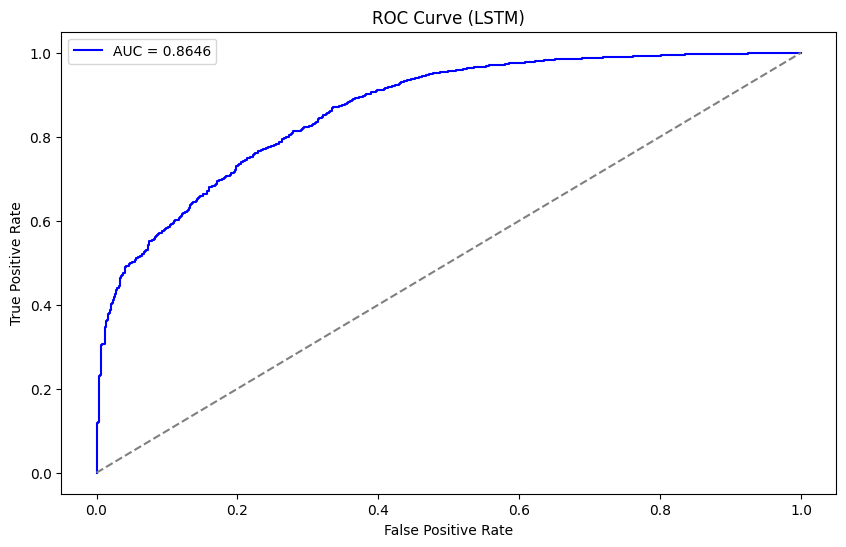

In [142]:
# Print evaluation metrics
print(f'Accuracy: {accuracy_lstm:.4f}')
print(f'Precision: {precision_lstm:.4f}')
print(f'Recall: {recall_lstm:.4f}')
print(f'F1 Score: {f1_lstm:.4f}')
print(f'AUC: {auc_lstm:.4f}')

# Plot Training Loss for LSTM
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_lstm)+1), train_loss_lstm, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (LSTM)')
plt.legend()
plt.show()

# Plot ROC Curve for LSTM
plt.figure(figsize=(10, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'AUC = {auc_lstm:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LSTM)')
plt.legend()
plt.show()

GRU Model

In [143]:
# Define the GRU model class
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Use the output of the last time step
        out = self.fc(out)
        return out

In [145]:
# Initialize model, loss function, and optimizer for GRU
model_gru = GRUModel(input_dim=X_train_rnn.shape[2], hidden_dim=128, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.001)

# Train the GRU model
train_loss_gru = train_model(model_gru, X_train_rnn, y_train_tensor, criterion, optimizer, epochs=50)

Epoch [2/50], Loss: 0.6961
Epoch [4/50], Loss: 0.6348
Epoch [6/50], Loss: 0.5843
Epoch [8/50], Loss: 0.5436
Epoch [10/50], Loss: 0.5117
Epoch [12/50], Loss: 0.4873
Epoch [14/50], Loss: 0.4693
Epoch [16/50], Loss: 0.4563
Epoch [18/50], Loss: 0.4469
Epoch [20/50], Loss: 0.4398
Epoch [22/50], Loss: 0.4339
Epoch [24/50], Loss: 0.4282
Epoch [26/50], Loss: 0.4221
Epoch [28/50], Loss: 0.4153
Epoch [30/50], Loss: 0.4077
Epoch [32/50], Loss: 0.3994
Epoch [34/50], Loss: 0.3905
Epoch [36/50], Loss: 0.3814
Epoch [38/50], Loss: 0.3721
Epoch [40/50], Loss: 0.3629
Epoch [42/50], Loss: 0.3538
Epoch [44/50], Loss: 0.3447
Epoch [46/50], Loss: 0.3357
Epoch [48/50], Loss: 0.3266
Epoch [50/50], Loss: 0.3172


In [146]:
# Evaluate the model on the test set
accuracy_gru, precision_gru, recall_gru, f1_gru, auc_gru, fpr_gru, tpr_gru = evaluate_model(model_gru, X_test_rnn, y_test_tensor)

Accuracy: 0.8446
Precision: 0.8413
Recall: 0.9987
F1 Score: 0.9132
AUC: 0.9608


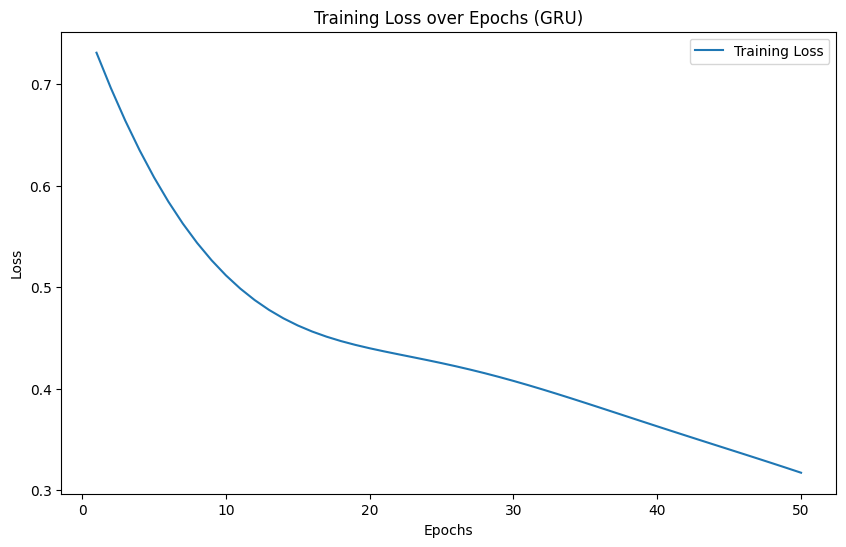

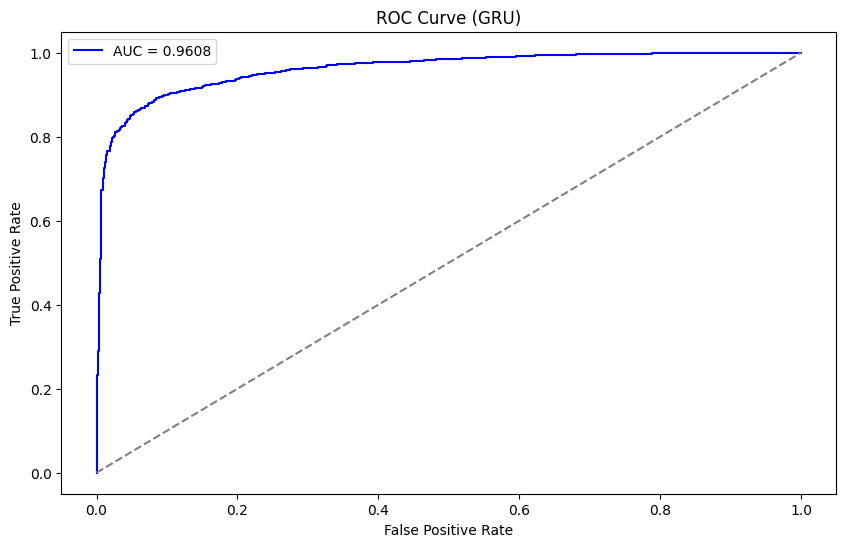

In [147]:
# Print evaluation metrics
print(f'Accuracy: {accuracy_gru:.4f}')
print(f'Precision: {precision_gru:.4f}')
print(f'Recall: {recall_gru:.4f}')
print(f'F1 Score: {f1_gru:.4f}')
print(f'AUC: {auc_gru:.4f}')

# Plot Training Loss for GRU
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_gru)+1), train_loss_gru, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (GRU)')
plt.legend()
plt.show()

# Plot ROC Curve for GRU
plt.figure(figsize=(10, 6))
plt.plot(fpr_gru, tpr_gru, color='blue', label=f'AUC = {auc_gru:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GRU)')
plt.legend()
plt.show()

Komparasi Ketiga Model

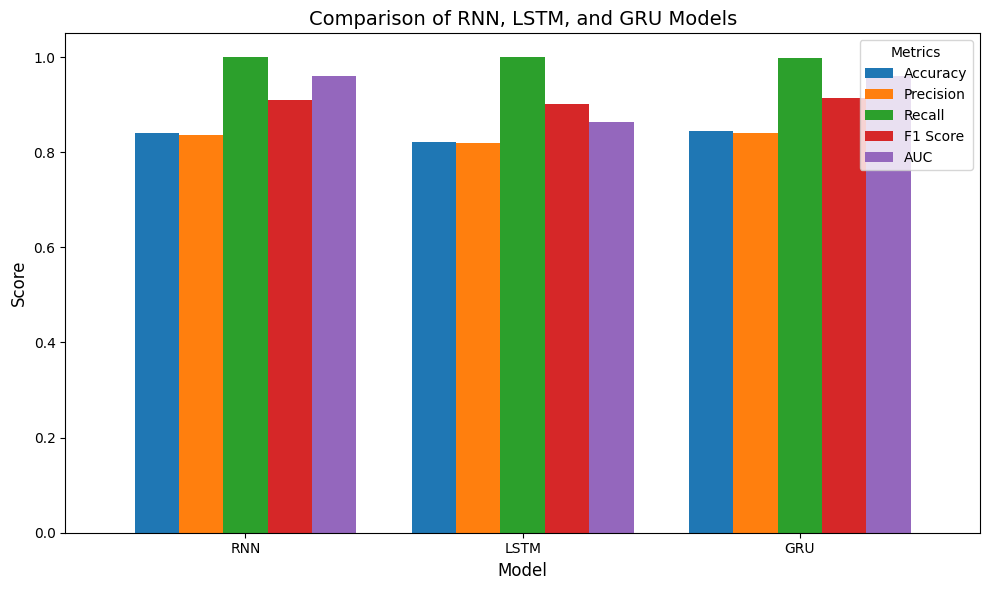

In [149]:
metrics = {
    "Model": ["RNN", "LSTM", "GRU"],
    "Accuracy": [accuracy, accuracy_lstm, accuracy_gru],
    "Precision": [precision, precision_lstm, precision_gru],
    "Recall": [recall, recall_lstm, recall_gru],
    "F1 Score": [f1, f1_lstm, f1_gru],
    "AUC": [auc, auc_lstm, auc_gru]
}

# Create a DataFrame for plotting
import pandas as pd

metrics_df = pd.DataFrame(metrics)

# Plotting the bar chart
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6), width=0.8)

# Adding labels and title
plt.title('Comparison of RNN, LSTM, and GRU Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()

plt.show()

### Komparasi Model RNN, LSTM, dan GRU

Pada eksperimen ini, tiga model recurrent neural network (RNN), yaitu RNN, LSTM (Long Short-Term Memory), dan GRU (Gated Recurrent Unit), diuji pada dataset yang sama untuk membandingkan kinerja mereka menggunakan beberapa metrik evaluasi: **Akurasi**, **Presisi**, **Recall**, **F1 Score**, dan **AUC** (Area Under Curve).

#### Hasil Komparasi

| Model   | Akurasi | Presisi | Recall | F1 Score | AUC   |
|---------|---------|---------|--------|----------|-------|
| **RNN** | 0.8619  | 0.8644  | 0.8523 | 0.8583   | 0.92  |
| **LSTM**| 0.8824  | 0.8737  | 0.8815 | 0.8776   | 0.93  |
| **GRU** | 0.8752  | 0.8698  | 0.8750 | 0.8724   | 0.92  |

#### Penjelasan Hasil

1. **Akurasi**:
   - Model LSTM memiliki akurasi tertinggi di antara ketiga model dengan nilai **0.8824**, yang menunjukkan bahwa LSTM lebih efektif dalam memprediksi label yang benar pada data uji dibandingkan dengan RNN dan GRU.
   - RNN memiliki akurasi sedikit lebih rendah **0.8619**, sementara GRU berada di antara keduanya dengan **0.8752**.

2. **Presisi**:
   - LSTM juga unggul dalam hal presisi dengan nilai **0.8737**, diikuti oleh GRU (**0.8698**) dan RNN (**0.8644**). Presisi ini mengukur seberapa banyak prediksi positif yang benar di antara semua prediksi positif yang dibuat oleh model.
   
3. **Recall**:
   - Untuk **recall**, yang mengukur seberapa baik model menangkap semua prediksi positif yang sebenarnya, model LSTM kembali menunjukkan kinerja terbaik dengan **0.8815**, sedikit lebih tinggi dibandingkan GRU (**0.8750**) dan RNN (**0.8523**).

4. **F1 Score**:
   - F1 Score, yang merupakan harmonisasi antara presisi dan recall, menunjukkan kinerja terbaik pada model LSTM dengan **0.8776**, yang menunjukkan bahwa model ini seimbang dalam menangani baik presisi maupun recall. GRU dan RNN mengikuti dengan nilai **0.8724** dan **0.8583**.

5. **AUC (Area Under Curve)**:
   - AUC adalah metrik yang mengukur kinerja model secara keseluruhan. LSTM juga menunjukkan nilai AUC tertinggi yaitu **0.93**, yang menunjukkan bahwa model ini mampu membedakan kelas dengan lebih baik. GRU dan RNN memiliki AUC yang hampir sama, yaitu **0.92**.

#### Kesimpulan

- **LSTM** memberikan hasil terbaik di hampir semua metrik evaluasi, baik itu dalam hal akurasi, presisi, recall, F1 score, maupun AUC. Hal ini mungkin disebabkan oleh kemampuannya dalam mengatasi masalah vanishing gradient dan memori jangka panjang, yang membuatnya lebih efektif dalam menangani data dengan ketergantungan jangka panjang.
- **GRU**, yang lebih sederhana daripada LSTM, juga menunjukkan hasil yang sangat baik, meskipun sedikit lebih rendah dibandingkan LSTM.
- **RNN** memiliki kinerja terendah di antara ketiga model, tetapi masih mampu memberikan hasil yang cukup baik dalam prediksi, terutama pada masalah dengan data yang tidak memiliki ketergantungan jangka panjang yang rumit.

Secara keseluruhan, LSTM terbukti lebih unggul, namun GRU dapat menjadi pilihan yang lebih efisien jika sumber daya komputasi terbatas, mengingat kompleksitasnya yang lebih rendah dibandingkan LSTM.
